# Analysis of f$_{NL}$ with DESI LRGs

This notebook will include snippets regarding the fNL project with DESI Imaging.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import modules as md

In [3]:
%matplotlib inline

In [4]:
md.dv.setup_color()

In [5]:
plt.rc('text', usetex=True)

## Create C_ell for mocks with fNL != 0
Create cosmologies with fNL to test the pipeline

In [ ]:
# md.create_cl()

## Cleaned data
First we prepare the data into `hpix`, `features`, `label`, and `fracgood`.

In [ ]:
# md.plot_radec()

## Target Density

## Selection Functions

In [ ]:
# # everything
# maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecals_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecals_256_known1/nn-weights.fits']
# md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desi_known1.hp256.fits')

# # w dec cuts
# maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_known1/nn-weights.fits']

# md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits')

# maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known2/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_known2/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_known2/nn-weights.fits']
# #print(maps)
# md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known2.hp256.fits')

# # w dec cuts & two extra maps
# maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalscext_256_known1ext/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalscext_256_known1ext/nn-weights.fits']

# md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1ext.hp256.fits')

# # known1 with imaging cuts
# maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzlsl_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalscl_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalscl_256_known1/nn-weights.fits']
# md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desicl_known1.hp256.fits')

# # known1 with fracgood cuts
# maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzlsf_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalscf_256_known1/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalscf_256_known1/nn-weights.fits']
# md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desicf_known1.hp256.fits')

# # all+nstar
# maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_allp/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_allp/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_allp/nn-weights.fits']
# md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_allp.hp256.fits')

# # cons2+nstar
# maps = ['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_bmzls_256_knownp/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_ndecalsc_256_knownp/nn-weights.fits',
#         '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_sdecalsc_256_knownp/nn-weights.fits']
# md.combine_nn(maps, '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_knownp.hp256.fits')

## DR9 Data

798.8351667806639


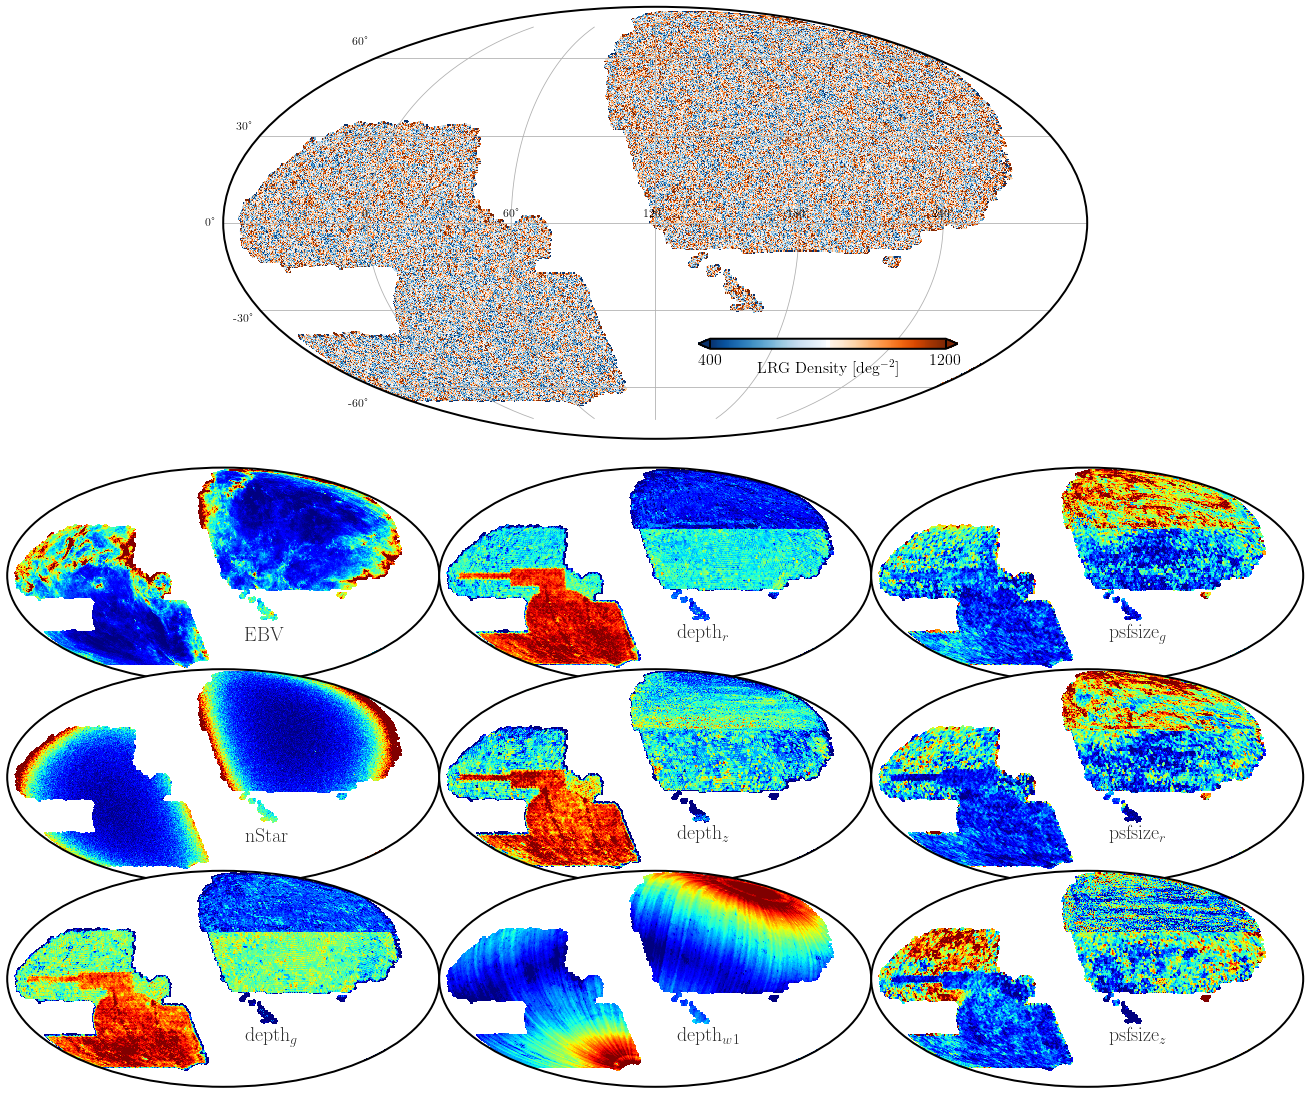

In [6]:
md.plot_xmaps()

Pearson Correlation Coefficient

100
bmzls done
100
ndecalsc done
100
sdecalsc done
(100, 9) 9
(100, 9) 9
(100, 9) 9


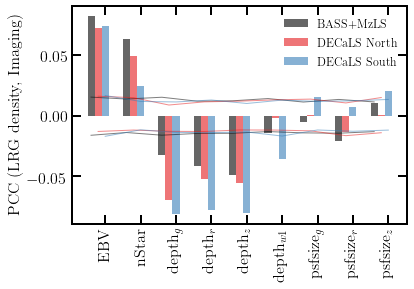

In [7]:
md.plot_pcc()

Pearson Correlation Coefficient

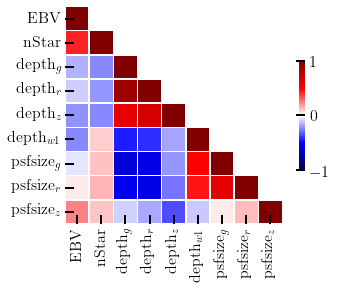

In [8]:
md.plot_corrmax()

## Cross Power

ell edges: [ 2  4  6  8 10 12 14 16 18 20]
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
nmocks: 1000, nbins: 81
nmocks: 1000, nbins: 81
Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81
Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81


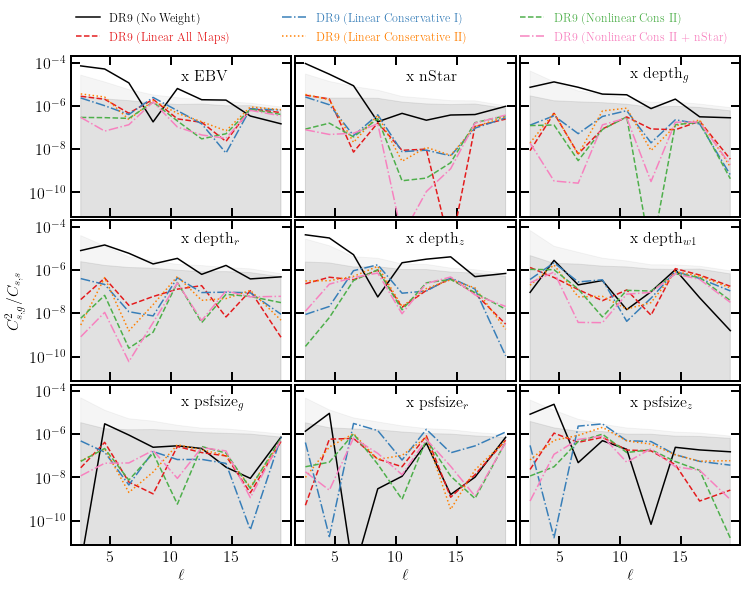

452.51439036526654 12.73599146545597
532.0629408864258 16.211484375059015
p-value: 0.0
p-value: 0.002
p-value: 0.044
p-value: 0.239
p-value: 0.594
p-value: 0.687


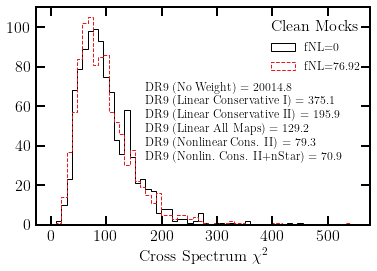

In [9]:
md.plot_clxtest()

0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 81)
nmocks: 1000, nbins: 81
Hartlap factor: 1.089422028353326
with nmocks: 1000 and nbins: 81
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 99)
nmocks: 1000, nbins: 99
Hartlap factor: 1.1112347052280311
with nmocks: 1000 and nbins: 99
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 117)
nmocks: 1000, nbins: 117
Hartlap factor: 1.133938706015891
with nmocks: 1000 and nbins: 117
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 135)
nmocks: 1000, nbins: 135
Hartlap factor: 1.1575898030127463
with nmocks: 1000 and nbins: 135
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
(1000, 153)
nmocks: 1000, nbins: 153
Hartlap factor: 1.1822485207100593
with nmocks: 1000 and nbins: 153


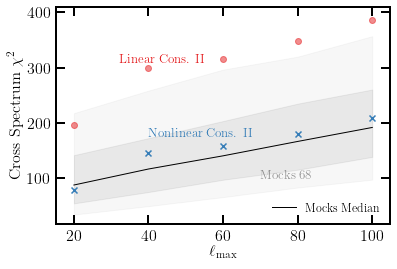

In [10]:
md.test_chi2lmax()

## Test of mean density contrast

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

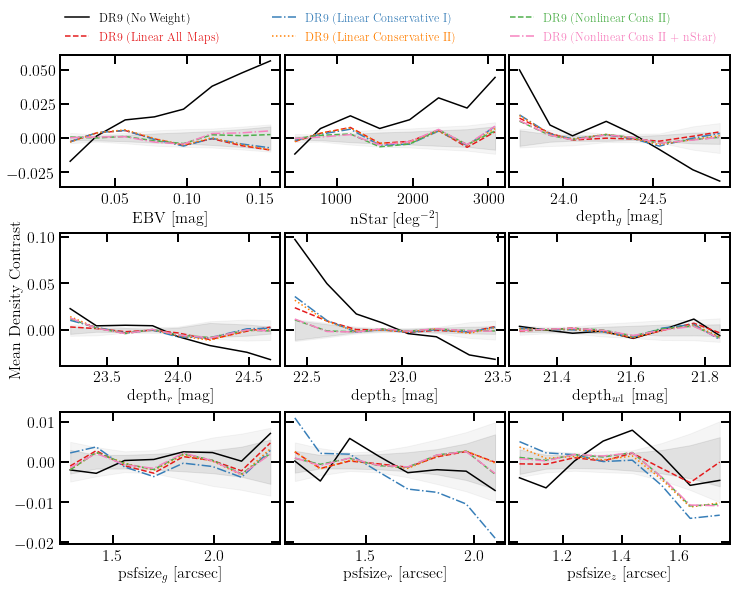

nmocks: 1000, nbins: 72
nmocks: 1000, nbins: 72
125.73479275585461 37.64838882795117
119.05340053084848 39.279522675915686
p-value: 0.0
p-value: 0.0
p-value: 0.0
p-value: 0.084
p-value: 0.392
p-value: 0.422


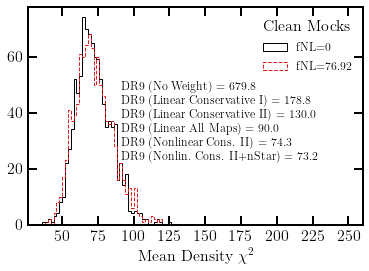

In [11]:
md.plot_nbartest()

## Bin C$_{\ell}$

In [ ]:
## --- only run once
# for region in ['ndecals', 'sdecals', 'bmzls', 
#                'ndecalsc', 'sdecalsc', 'desic',
#                'bmzlsl', 'ndecalscl', 'sdecalscl', 'desicl',
#                'bmzlsf', 'ndecalscf', 'sdecalscf', 'desicf']:
#     md.bin_clmock('zero', region, '0', 'noweight', md.ut.ell_edges, log=True)
    
#     if region == 'desic':
#         md.bin_clmock('czero', region, '0',  'noweight', md.ut.ell_edges, log=True)           
#         md.bin_clmock('po100', region, '0',  'noweight', md.ut.ell_edges, log=True)   
#         md.bin_clmock('cpo100', region, '0', 'noweight', md.ut.ell_edges, log=True)   
        
#         # mitigated
#         for fnlt in  ['czero', 'cpo100', 'zero','po100']:
#             for map_ in ['dnnp_known1', 'dnnp_knownp', 'dnnp_allp']:
#                 md.bin_clmock(fnlt, region, '0', map_, md.ut.ell_edges, log=True)        

## Histogram of C$_{\ell}$ vs log(C$_{\ell}$)

bins [  2   4   6   8  10  12  14  16  18  20  30  40  50  60  70  80  90 100
 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280
 290 300]


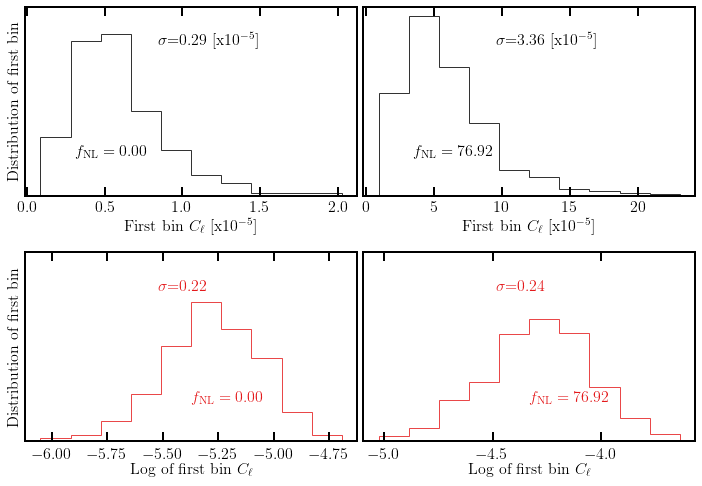

In [12]:
md.plot_clhist()

## Fitting $f_{\rm NL}$

### Best fit

-5.656438116009658
13.430539026178407


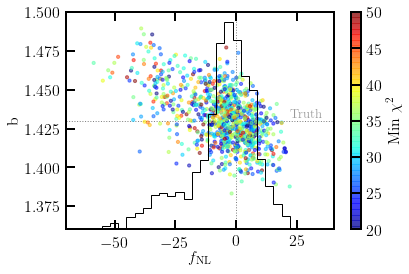

73.63068685515955
14.924500590722802


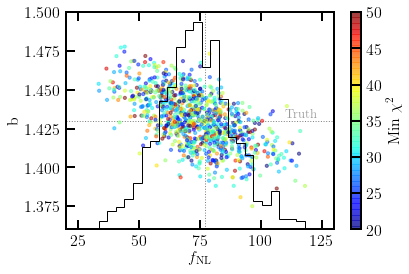

In [13]:
md.plot_bestfit()

### MCMC Contours

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


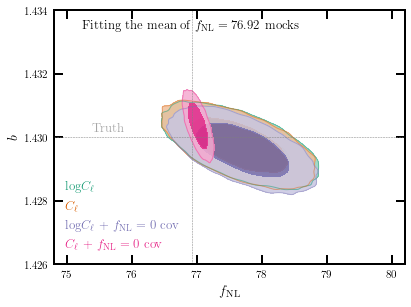

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
$76.92$ & DESI & log$C_{\ell}$          & $ 77.67$& $ 77.67$& $ 77.17<\fnl< 78.16$& $ 76.71<\fnl< 78.64$ &   38.8\\
$76.92$ & DESI & $C_{\ell}$             & $ 77.67$& $ 77.65$& $ 77.17<\fnl< 78.14$& $ 76.70<\fnl< 78.60$ &   39.0\\
$76.92$ & DESI & log$C_{\ell}$ + $f_{\rm NL}=0$ cov & $ 77.70$& $ 77.71$& $ 77.25<\fnl< 78.17$& $ 76.81<\fnl< 78.63$ &   39.9\\
$76.92$ & DESI & $C_{\ell}$ + $f_{\rm NL}=0$ cov & $ 77.03$& $ 77.02$& $ 76.93<\fnl< 77.12$& $ 76.83<\fnl< 77.22$ &  207.6\\
$0$ & DESI         &  log$C_{\ell}$     & $  0.36$& $  0.36$& $  0.06<\fnl<  0.65$& $ -0.23<\fnl<  0.94$ &   35.7\\
$0$ & BASS+MzLS    &  log$C_{\ell}$     & $  0.83$& $  0.82$& $  0.25<\fnl<  1.40$& $ -0.31<\fnl<  1.96$ &   39.4\\
$0$ & DECaLS North &  log$C_{\ell}$     & $  0.07$& $  0.06$& $ -0.47<\fnl<  0.60$& $ -1.00<\fnl<  1.12$ &   26.7\\
$0$ & DECaLS South &  log$C_{\ell}$     & $  0.67$& $  0.67$& $  0.13<\fnl<  1.22$& $ -0.40

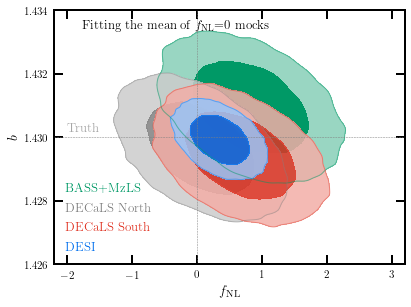

In [23]:
md.plot_mcmc_mocks()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
$0$ & No Weight                         & $  0.36$& $  0.36$& $  0.06<\fnl<  0.65$& $ -0.23<\fnl<  0.94$ &   35.7\\
$0$ & ConsII                            & $-11.64$& $-11.65$& $-12.00<\fnl<-11.30$& $-12.34<\fnl<-10.97$ &   86.8\\
$0$ & ConsII+nStar                      & $-20.14$& $-20.13$& $-20.44<\fnl<-19.82$& $-20.74<\fnl<-19.52$ &  472.8\\
$0$ & All Maps+nStar                    & $-26.91$& $-26.92$& $-27.16<\fnl<-26.68$& $-27.39<\fnl<-26.46$ & 5481.0\\
Cont $0$ & ConsII                       & $-12.12$& $-12.13$& $-12.48<\fnl<-11.78$& $-12.83<\fnl<-11.44$ &   94.0\\
Cont $0$ & ConsII+nStar                 & $-20.97$& $-20.98$& $-21.28<\fnl<-20.67$& $-21.58<\fnl<

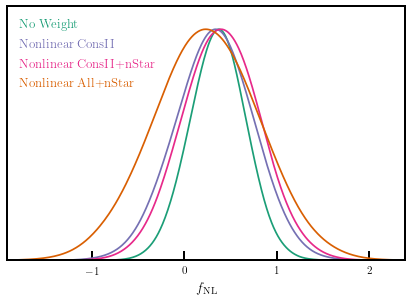

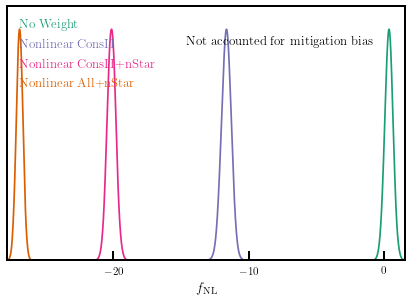

In [26]:
md.plot_mcmc_contmocks()

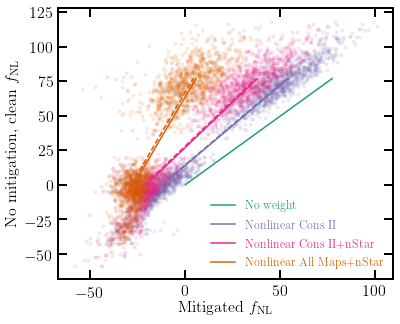

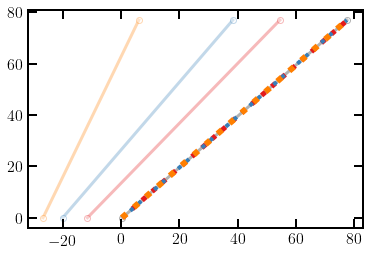

In [16]:
md.plot_fnlbias()

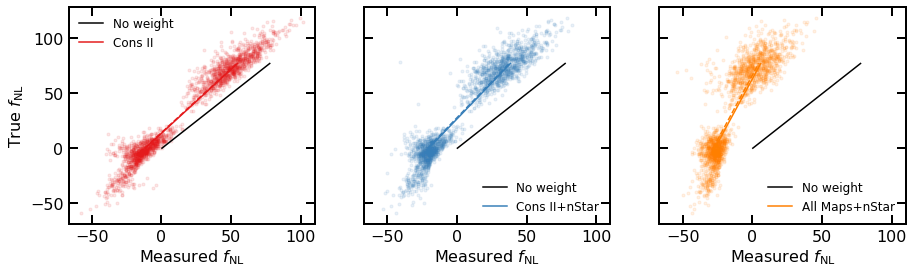

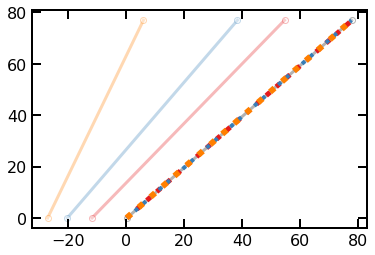

In [19]:
md.plot_fnlbias()

In [14]:
## --- run once
# md.debias_mcmc()
# md.debias_mcmc_mocks()

/fs/ess/PHS0336/data/lognormal/v3/mcmc/logmcmc_0_lrg_zero_desic_256_dnnp_known1debiased_steps10k_walkers50.npz
-11.646233657183204
0.323906621095649
/fs/ess/PHS0336/data/lognormal/v3/mcmc/logmcmc_0_lrg_zero_desic_256_dnnp_knownpdebiased_steps10k_walkers50.npz
-20.131682795112685
0.39617871045125774
/fs/ess/PHS0336/data/lognormal/v3/mcmc/logmcmc_0_lrg_zero_desic_256_dnnp_allpdebiased_steps10k_walkers50.npz
-26.921515285586384
0.2344390788719958


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


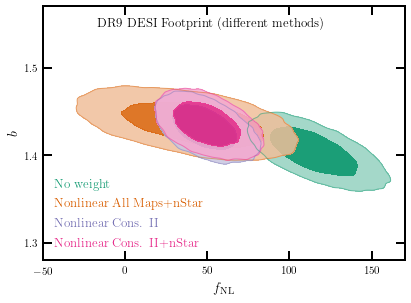

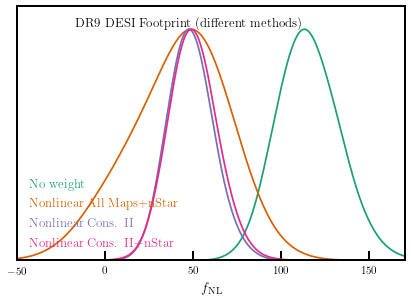

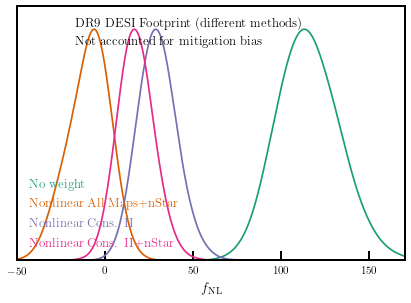

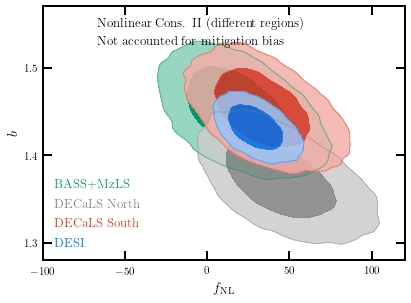

DESI                      & No Weight   & $113.18$& $115.49$& $ 98.14<\fnl<132.89$& $ 83.51<\fnl<151.59$ &   44.4\\
DESI                      & Linear (All Maps)& $ 36.05$& $ 37.72$& $ 26.13<\fnl< 49.21$& $ 16.31<\fnl< 62.31$ &   41.1\\
DESI                      & Linear (Conservative I)& $ 49.58$& $ 51.30$& $ 38.21<\fnl< 64.33$& $ 27.41<\fnl< 78.91$ &   38.8\\
DESI                      & Linear (Conservative II)& $ 36.63$& $ 38.11$& $ 26.32<\fnl< 49.86$& $ 16.36<\fnl< 63.12$ &   39.6\\
DESI                      & Nonlinear (Cons. II)& $ 28.58$& $ 29.79$& $ 18.91<\fnl< 40.59$& $  9.47<\fnl< 52.73$ &   34.6\\
DESI                      & Nonlin. (Cons. II+nStar)& $ 16.63$& $ 17.52$& $  7.51<\fnl< 27.53$& $ -1.59<\fnl< 38.49$ &   35.2\\
DESI                      & Nonlin. (All Maps+nStar)& $ -5.87$& $ -9.19$& $-21.45<\fnl<  2.40$& $-33.81<\fnl< 12.06$ &   39.5\\
DESI (imag. cut)          & Nonlin. (Cons. II)& $ 29.16$& $ 30.57$& $ 19.05<\fnl< 42.18$& $  9.01<\fnl< 54.81$ &   35.8\\
DESI (

In [21]:
md.plot_mcmc_data()

In [17]:
md.ut.ell_edges.size-1 - 3 # num of data points: 37, dof = 37 - 3 = 33

34

## Reshift Distribution

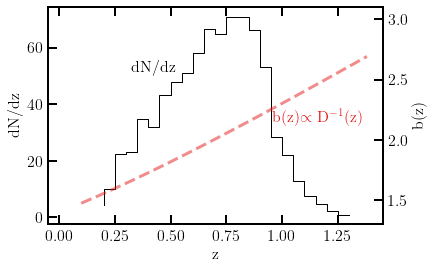

In [27]:
md.plot_nz()

## Model vs Observations

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0
0.36359642736202175 1.4299247130148807


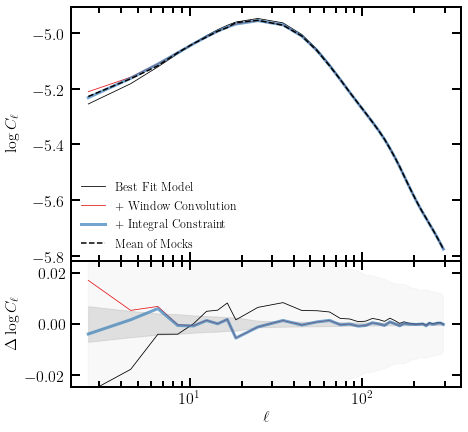

In [16]:
md.plot_model('zero')

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.0
Linear All Maps 36.05310065845671 1.436296182456702
Linear Conservative I 49.58384648962971 1.4351518629674762
Linear Conservative II 36.633206055833334 1.440345736458642
Nonlinear Cons. II 28.57684133162572 1.4322088642875044
Nonlinear Cons. II+nStar 16.626116807074606 1.4358145957898807
No weight 113.17500763020482 1.404533099226912


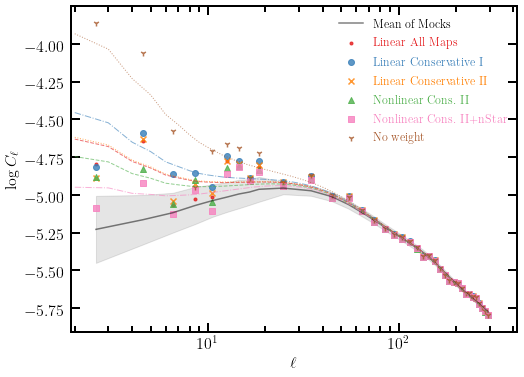

In [8]:
md.plot_dr9cl()

## f$_{\rm NL}$ vs $\ell_{\rm min}$

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

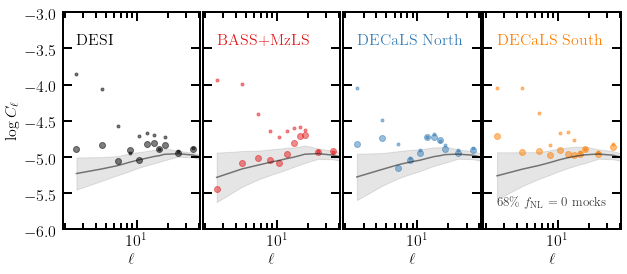

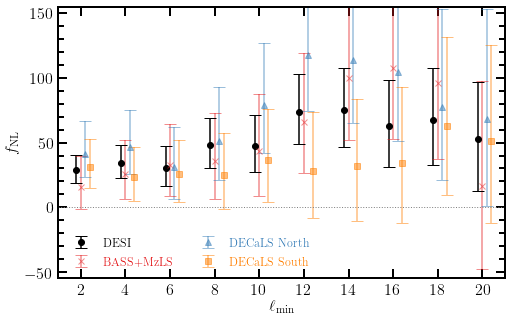

In [30]:
md.plot_fnl_lmin()

## ANYTHING BELOW IS FOR TESTING NEW IDEAS

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
p = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/logbestfit_0_lrg_po100_desic_256_noweight.npz')
pp = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/logbestfit_0_lrg_po100_desic_256_dnnp_allp.npz')
z = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/logbestfit_0_lrg_zero_desic_256_noweight.npz')
zp = np.load('/fs/ess/PHS0336/data/lognormal/v3/mcmc/logbestfit_0_lrg_zero_desic_256_dnnp_allp.npz')

Text(0, 0.5, 'True $f_{\\rm NL}$')

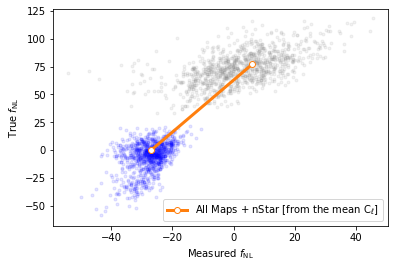

In [29]:
plt.scatter(pp['params'][:, 0]/1.3, p['params'][:, 0]/1.3, alpha=0.1, marker='.', c='grey')
plt.scatter(zp['params'][:, 0]/1.3, z['params'][:, 0]/1.3, alpha=0.1, marker='.', c='blue')


truth  = np.array([0.0,    76.92])
meas0  = np.array([0.36,   77.67])
meas1  = np.array([-11.64, 54.57])
meas2  = np.array([-20.14, 38.38])
meas3  = np.array([-26.91, 6.04])
measc1 = np.array([-12.12, 54.01])
measc2 = np.array([-20.97, 37.48])
measc3 = np.array([-28.13, 4.59])


plt.plot(meas3, truth, label=r'All Maps + nStar [from the mean C$_{\ell}$]', lw=3, marker='o', mfc='w', ls='-', color='C1')
plt.legend()
plt.xlabel(r'Measured $f_{\rm NL}$')
plt.ylabel(r'True $f_{\rm NL}$')

In [ ]:
# md.test_nz()

In [5]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import fitsio as ft
from glob import glob
import sys
sys.path.insert(0, '/users/PHS0336/medirz90/github/LSSutils')
import lssutils.utils as ut

In [6]:
r0 = np.loadtxt('/fs/ess/PHS0336/data/goliat/honda.ift.uam-csic.es/angular_mocks/randoms_radecz_highz/Random_j1Gpc_x22_F_equat2_fnl0_highz.txt')
r1 = np.loadtxt('/fs/ess/PHS0336/data/goliat/honda.ift.uam-csic.es/angular_mocks/randoms_radecz_highz/Random_j1Gpc_x22_FP_equat3_fnl0_highz.txt')
r = np.concatenate([r0, r1])
rm = ut.hpixsum(256, r[:, 0], r[:, 1])*1.0
mask = rm > 0

In [ ]:
cell = {}
for fnl in [0, -100, 100]:
    mocks = glob(f'/fs/ess/PHS0336/data/goliat/honda.ift.uam-csic.es/angular_mocks/halo_catalogs_radecz_real_highz/fnl{fnl}/j1Gpc*fnl{fnl}_highz.txt')
    print(fnl, len(mocks))
    
    cls = []
    for mock in mocks:

        d = np.loadtxt(mock)
        dm = ut.hpixsum(256, d[:, 0], d[:, 1])*1.0
        dl = ut.make_overdensity(dm, rm, mask)

        dl[~mask] = hp.UNSEEN
        cl = hp.anafast(dl*rm/rm[mask].mean()) / mask.mean()
        cls.append(cl)
        print('.', end='')    
    print(fnl)
    cell[fnl] = np.array(cls)
    
np.savez("/fs/ess/PHS0336/data/goliat/pseudocl.npz", cell)    

In [7]:
cell = np.load('/fs/ess/PHS0336/data/goliat/pseudocl.npz', allow_pickle=True)['arr_0'].item()

In [8]:
2

2

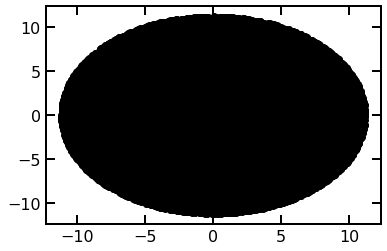

In [9]:
plt.scatter(r[::100, 0], r[::100, 1])
# plt.scatter(d[::100, 0], d[::100, 1])

In [10]:
zg = np.arange(0., 2.0, 0.01)
zm = 0.5*(zg[1:]+zg[:-1])
nz = np.histogram(r[:, 2], bins=zg, density=True)[0]

In [11]:
from lssutils.theory.cell import SurveySpectrum

In [12]:
sp = SurveySpectrum(h=0.7, n_s=0.96, sigma8=0.8, Omega0_b=0.044, Omega0_cdm=0.226)

h         : 0.7
T0_cmb    : 2.7255
Omega0_b  : 0.044
Omega0_cdm: 0.226
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8
gauge     : synchronous
n_s       : 0.96
nonlinear : False


In [13]:
sp.add_tracer(zm, np.ones_like(zm), nz, p=0.9)

p = 0.9


In [14]:
el = np.arange(1000)

In [15]:
rm1024 = ut.hpixsum(1024, r[:, 0], r[:, 1])*1.0

In [16]:
maskh = rm1024 > 0

In [17]:
sp.add_window(rm1024/rm1024[maskh].mean(), maskh, np.arange(2048), ngauss=2048)

will create windows
0 (122, 768) [8.18426737e-16 1.44366123e-14 7.95508856e-16 7.51551360e-15
 1.76591671e-14 7.44425758e-15 2.72716255e-15 1.51600338e-15
 2.84875326e-15 4.11209008e-16] [1.58689684e-28 6.08390002e-14 5.19687032e-13]
-100 (246, 768) [2.91920157e-16 2.14472602e-15 2.03116980e-16 8.15186519e-16
 6.57297836e-16 5.43405219e-15 1.29618888e-15 1.30366281e-14
 5.77136410e-16 1.17876988e-15] [1.08735151e-28 1.49164496e-14 1.27055440e-13]
100 (246, 768) [1.73102797e-15 1.19936076e-14 4.83703953e-16 7.03020605e-15
 5.68295907e-15 2.72233317e-15 3.15306464e-15 2.51447400e-15
 1.55364262e-17 2.51447400e-15] [1.18988247e-28 1.59306803e-13 1.36318403e-12]


[]

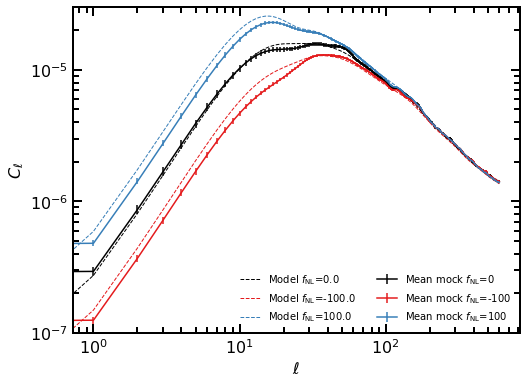

In [18]:
plt.figure(figsize=(8, 6))

for i, (n, v) in enumerate(cell.items()):

    ln = plt.errorbar(el[:600], np.mean(v, axis=0)[:600], 
                     yerr=np.std(v, axis=0)[:600]/np.sqrt(v.shape[0]), 
                      label=r'Mean mock $f_{\rm NL}$=%s'%n, color='C%d'%i)
    fnl_m = n
    plt.plot(sp(el, fnl=fnl_m*1.3, b=2.27, noise=8.9e-7)[:600], 
             label=r'Model $f_{\rm NL}$=%0.1f'%fnl_m, color='C%d'%i, ls='--', lw=1)
    
    print(n, v.shape, v[:10, 0], np.var(v, axis=0)[:3])
plt.legend(loc='lower right', ncol=2, fontsize=10)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
# plt.yscale('symlog', linthreshy=1.0e-7)
# plt.xscale('symlog', linthreshx=1)
plt.ylim(1.0e-7, 3.0e-5)
plt.loglog()

# plt.savefig('goliat_cl.png', dpi=300, bbox_inches='tight')

In [19]:
cell.keys()

dict_keys([0, -100, 100])

In [36]:
delta = {0:, -100:-40, 100:-25}

0 (122, 768) [8.18426737e-16 1.44366123e-14 7.95508856e-16 7.51551360e-15
 1.76591671e-14 7.44425758e-15 2.72716255e-15 1.51600338e-15
 2.84875326e-15 4.11209008e-16] [1.58689684e-28 6.08390002e-14 5.19687032e-13]
-100 (246, 768) [2.91920157e-16 2.14472602e-15 2.03116980e-16 8.15186519e-16
 6.57297836e-16 5.43405219e-15 1.29618888e-15 1.30366281e-14
 5.77136410e-16 1.17876988e-15] [1.08735151e-28 1.49164496e-14 1.27055440e-13]
100 (246, 768) [1.73102797e-15 1.19936076e-14 4.83703953e-16 7.03020605e-15
 5.68295907e-15 2.72233317e-15 3.15306464e-15 2.51447400e-15
 1.55364262e-17 2.51447400e-15] [1.18988247e-28 1.59306803e-13 1.36318403e-12]


[]

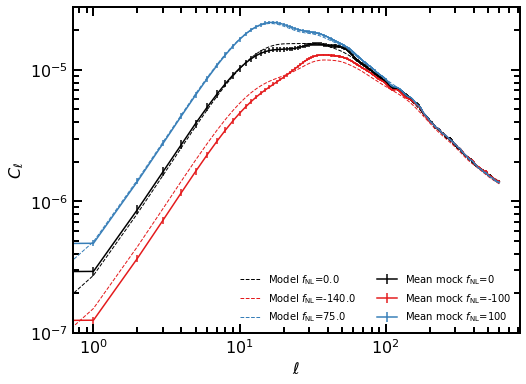

In [39]:
plt.figure(figsize=(8, 6))

for i, (n, v) in enumerate(cell.items()):

    ln = plt.errorbar(el[:600], np.mean(v, axis=0)[:600], 
                     yerr=np.std(v, axis=0)[:600]/np.sqrt(v.shape[0]), 
                      label=r'Mean mock $f_{\rm NL}$=%s'%n, color='C%d'%i)
    fnl_m = n+delta[n]
    plt.plot(sp(el, fnl=fnl_m*1.3, b=2.27, noise=8.9e-7)[:600], 
            label=r'Model $f_{\rm NL}$=%0.1f'%fnl_m, color='C%d'%i, ls='--', lw=1)    
    
    print(n, v.shape, v[:10, 0], np.var(v, axis=0)[:3])
plt.legend(loc='lower right', ncol=2, fontsize=10)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
# plt.yscale('symlog', linthreshy=1.0e-7)
# plt.xscale('symlog', linthreshx=1)
plt.ylim(1.0e-7, 3.0e-5)
plt.loglog()

# plt.savefig('goliat_cl.png', dpi=300, bbox_inches='tight')

0 (122, 768) [8.18426737e-16 1.44366123e-14 7.95508856e-16 7.51551360e-15
 1.76591671e-14 7.44425758e-15 2.72716255e-15 1.51600338e-15
 2.84875326e-15 4.11209008e-16] [1.58689684e-28 6.08390002e-14 5.19687032e-13]
-100 (246, 768) [2.91920157e-16 2.14472602e-15 2.03116980e-16 8.15186519e-16
 6.57297836e-16 5.43405219e-15 1.29618888e-15 1.30366281e-14
 5.77136410e-16 1.17876988e-15] [1.08735151e-28 1.49164496e-14 1.27055440e-13]
100 (246, 768) [1.73102797e-15 1.19936076e-14 4.83703953e-16 7.03020605e-15
 5.68295907e-15 2.72233317e-15 3.15306464e-15 2.51447400e-15
 1.55364262e-17 2.51447400e-15] [1.18988247e-28 1.59306803e-13 1.36318403e-12]


[]

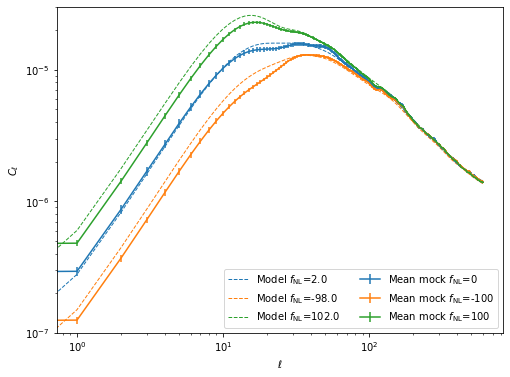

In [17]:
plt.figure(figsize=(8, 6))

for i, (n, v) in enumerate(cell.items()):

    ln = plt.errorbar(el[:600], np.mean(v, axis=0)[:600], 
                     yerr=np.std(v, axis=0)[:600]/np.sqrt(v.shape[0]), 
                      label=r'Mean mock $f_{\rm NL}$=%s'%n, color='C%d'%i)
    fnl_m = n+2
    plt.plot(sp(el, fnl=fnl_m*1.3, b=2.27, noise=8.9e-7)[:600], 
             label=r'Model $f_{\rm NL}$=%0.1f'%fnl_m, color='C%d'%i, ls='--', lw=1)
    
    print(n, v.shape, v[:10, 0], np.var(v, axis=0)[:3])
plt.legend(loc='lower right', ncol=2, fontsize=10)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
# plt.yscale('symlog', linthreshy=1.0e-7)
# plt.xscale('symlog', linthreshx=1)
plt.ylim(1.0e-7, 3.0e-5)
plt.loglog()

# plt.savefig('goliat_cl.png', dpi=300, bbox_inches='tight')

0 (122, 768) [8.18426737e-16 1.44366123e-14 7.95508856e-16 7.51551360e-15
 1.76591671e-14 7.44425758e-15 2.72716255e-15 1.51600338e-15
 2.84875326e-15 4.11209008e-16] [1.58689684e-28 6.08390002e-14 5.19687032e-13]
-100 (246, 768) [2.91920157e-16 2.14472602e-15 2.03116980e-16 8.15186519e-16
 6.57297836e-16 5.43405219e-15 1.29618888e-15 1.30366281e-14
 5.77136410e-16 1.17876988e-15] [1.08735151e-28 1.49164496e-14 1.27055440e-13]
100 (246, 768) [1.73102797e-15 1.19936076e-14 4.83703953e-16 7.03020605e-15
 5.68295907e-15 2.72233317e-15 3.15306464e-15 2.51447400e-15
 1.55364262e-17 2.51447400e-15] [1.18988247e-28 1.59306803e-13 1.36318403e-12]


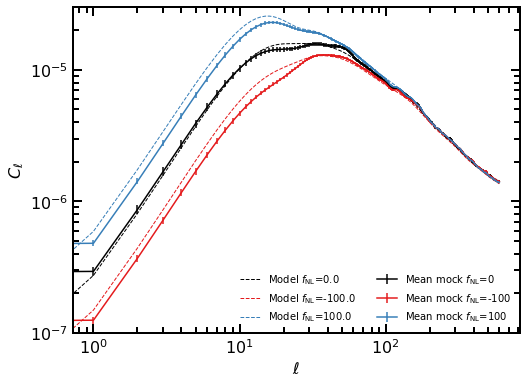

0 (122, 768) [8.18426737e-16 1.44366123e-14 7.95508856e-16 7.51551360e-15
 1.76591671e-14 7.44425758e-15 2.72716255e-15 1.51600338e-15
 2.84875326e-15 4.11209008e-16] [1.58689684e-28 6.08390002e-14 5.19687032e-13]


(1e-06, 1.2e-05)

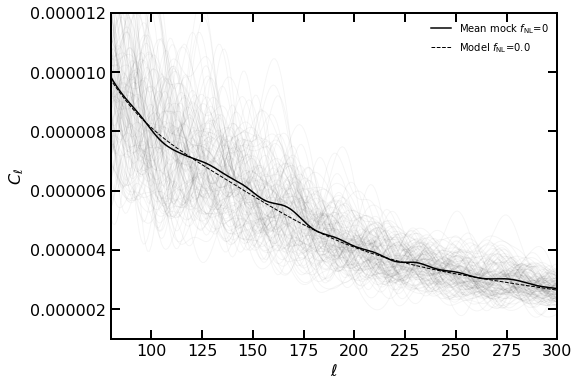

In [49]:
plt.figure(figsize=(8, 6))

for i, (n, v) in enumerate(cell.items()):

    plt.plot(el[:600], np.mean(v, axis=0)[:600], 
                  label=r'Mean mock $f_{\rm NL}$=%s'%n, color='C%d'%i, ls='-')
    for v_i in v:
        
        plt.plot(el[:600], v_i[:600], color='C%d'%i, ls='-', zorder=-10, lw=1, alpha=0.04)


    fnl_m = n
    plt.plot(sp(el, fnl=fnl_m*1.3, b=2.27, noise=8.9e-7)[:600], 
             label=r'Model $f_{\rm NL}$=%0.1f'%fnl_m, color='C%d'%i, ls='--', lw=1)
    
    print(n, v.shape, v[:10, 0], np.var(v, axis=0)[:3])
    break
plt.legend(loc='upper right', fontsize=10)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.xlim(80, 300)
plt.ylim(1.0e-6, 12.0e-6)
# plt.yscale('symlog', linthreshy=1.0e-7)
# plt.xscale('symlog', linthreshx=1)
# plt.ylim(1.0e-7, 3.0e-5)
# plt.loglog()

# plt.savefig('goliat_cl.png', dpi=300, bbox_inches='tight')

In [ ]:
# meas0  = md.np.array([0.36,   77.67])
# meas1  = md.np.array([-20.14, 38.38])


# a = (meas0[0]-meas0[1])/(meas1[0]-meas1[1])
# b = (meas1[0]*meas0[1]-meas1[1]*meas0[0])/(meas1[0]-meas1[1])

In [ ]:
1.17*28.58+13.95, 1.32*16.63+26.97, 2.35*-5.87+63.50

In [ ]:
p = '/fs/ess/PHS0336/data/lognormal/v3/clustering/'

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharey=True, sharex=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.02, hspace=0.02)

names = ['No Weight', 'Cons II', 'Cons II+nStar']
label = [r'$f_{\rm NL}$=0', r'Contaminated $f_{\rm NL}$=0', 
         r'$f_{\rm NL}$=100', r'Contaminated $f_{\rm NL}$=100']

color = 2*['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for i, fnl in enumerate(['zero', 'czero', 'po100', 'cpo100']):
    
    for j,m in enumerate(['noweight', 'dnnp_known1', 'dnnp_knownp']):
        
        cl = np.load(f'{p}logclmock_0_lrg_{fnl}_desic_256_{m}_mean.npz')
        ax[i].plot(cl['el_bin'], cl['cl'], label=names[j], marker='.', color=color[i*3+j])
        
        if (not 'c' in fnl) & (m=='noweight'):
            ax[i+1].plot(cl['el_bin'], cl['cl'], marker='.', 
                        color=color[0], ls='-', label='Truth')
            
    ax[i].set_xscale('log')
    ax[i].text(0.25, 0.1, label[i], transform=ax[i].transAxes, color='grey')
    ax[i].grid(True, ls=':')
    
    if i%2==0:ax[i].set_ylabel(r'$\log C_{\ell}$')
    if i>1:ax[i].set_xlabel(r'$\ell$')
ax[1].legend()
ax[0].legend()

In [ ]:
class Chains:
    def __init__(self, filename, plot=False):    
        chains_ = np.load(filename, allow_pickle=True)
        self.chains = chains_['chain']
        self.stats = {'x':chains_['x']}#, 'y':chains_['y']}
        print(self.chains.shape)
        self.ndim = self.chains.shape[-1]
        #if plot:
        #    fg, ax = plt.subplots(nrows=12, figsize=(8, 12*1), sharex=True)#, sharey=True)
        #    ax = ax.flatten()
        #    #ax[0].set_ylim(-.5, .5)
        #    for i, ix in enumerate(range(12)): #[0, 1, 2, 3, 5]):
        #        for j in range(400):
        #            ax[i].plot(self.chains[:, j, ix])
        #        ax[i].axhline(0.0, ls=':')    
        #    fg.show()
        
    def get_sample(self, skip_rows=200):
        return self.chains[skip_rows:, :, :].reshape(-1, self.ndim)
    
def modelp(x, theta):
    """ Linear model Poisson """
    u = x.dot(theta[1:]) + theta[0]    
    is_high = u > 20
    ret = u*1
    ret[~is_high] = np.log(1.+np.exp(u[~is_high]))
    return ret    

In [ ]:
pm = Chains('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/linp_lrg_bmzls_256_known1/mcmc_bmzls_known1.npz')
d = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
mock = hp.read_map('/fs/ess/PHS0336/data/lognormal/v3/hpmaps/lrghp-zero-10-f1z1.fits')

mask = md.ut.make_hp(256, d['hpix'], 1.0) > 0.5
x = (d['features'][:, [0, 4, 7]] - pm.stats['x'][0]) / pm.stats['x'][1] # known1
params = pm.get_sample(skip_rows=1000)

In [ ]:
dm = hp.ma(mock/np.mean(mock[mask])-1.0)
dm.mask = np.logical_not(mask)
clm = hp.anafast(dm.filled())

In [ ]:
cl_cmocks = []
for i in np.random.randint(0, 400000, size=100):
    
    m_i = modelp(x, params[i, :])
    wt_i = md.ut.make_hp(256, d['hpix'], m_i/m_i.mean())
    
    cmock = np.zeros_like(mock)
    cmock[mask] = mock[mask]*wt_i[mask]
    
    dcm = hp.ma(cmock/np.mean(cmock[mask])-1.0)
    dcm.mask = np.logical_not(mask)
    
    cl_cmocks.append(hp.anafast(dcm.filled()))
    print('.', end='')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 8), sharex=True)
fig.subplots_adjust(hspace=0.02)


ax2.plot(1.e5*clm, color='C0', lw=1, zorder=-10)

for cl_i in cl_cmocks:
    ax1.plot(cl_i/np.mean(cl_cmocks, axis=0), ls='-', color='C1', lw=1, alpha=0.2)
    ax2.plot(1.e5*cl_i, ls='-', color='C1', lw=1, alpha=0.2)
    
ax1.set(xscale='log', ylabel=r'$C_{\ell}$/<$C_{\ell}$>')
ax2.set(xlabel=r'$\ell$', ylabel=r'$C_{\ell}~[x10^{-5}]$', yscale='log', ylim=(1.0e-3, 1.0e1))
# plt.ylim(1.0e-8, 1.0e-4)

In [ ]:
!qstat -u medirz90

In [ ]:
d1 = hp.read_map('/fs/ess/PHS0336/data/lognormal/v3/hpmaps/lrghp-czero-955-f1z1.fits')
d0 = hp.read_map('/fs/ess/PHS0336/data/lognormal/v3/hpmaps/lrghp-zero-955-f1z1.fits')

In [ ]:
mask = d1 != hp.UNSEEN
d0[~mask] = hp.UNSEEN

In [ ]:
d0[mask] = d0[mask]/d0[mask].mean()-1.
d1[mask] = d1[mask]/d1[mask].mean()-1.

In [ ]:
plt.plot(hp.anafast(d0))
plt.plot(hp.anafast(d1))
plt.xlim(-0.5, 10)
# plt.ylim(1.0e-7, 1.0e-4)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
for fn in ['zero', 'czero', 
           'po100', 'cpo100']:
    
    fn0 = fn[1:] if 'c' in fn else fn
    print(fn, fn0)
    d1  = d = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_1_lrg_{fn}_desic_256_dnnp_known1.npy', allow_pickle=True).item()['cl_gg']['cl']
    d0 = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_1_lrg_{fn0}_desic_256_noweight.npy', allow_pickle=True).item()['cl_gg']['cl']

    
    fn_ = 0 if 'zero' in fn else 100
    tag_ = 'Contaminated' if 'c' in fn else ''
    plt.semilogx(1.0e+5*(d1-d0), label=f'{tag_} fNL={fn_}')
    
plt.legend()
#plt.yscale('symlog', linthreshy=1e-5)
#plt.ylim(-1.0e-3, 1.0e-3)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{5} \Delta$C$_{\ell}$ (weights applied-truth)')

In [ ]:
d0 = md.np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_desic_256_noweight.npy', allow_pickle=True)
d1 = md.np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_desic_256_dnnp_known1.npy', allow_pickle=True)
d = md.np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_desic_256_dnnp_knownp.npy', allow_pickle=True)

In [ ]:
md.plt.plot(d0[1]['bin_avg'], d0[1]['nnbar'], label='No weight')
md.plt.plot(d1[1]['bin_avg'], d1[1]['nnbar'], label='Cons II', marker='.')
md.plt.plot(d[1]['bin_avg'], d[1]['nnbar'], label='Cons II+nStar', marker='.')

md.plt.legend()
md.plt.xlabel('nStar')
md.plt.ylabel('mean LRG density')

In [ ]:
for r in ['known1', 'allp']:
    d = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_dnnp_{r}.npy', allow_pickle=True).item()
    plt.loglog(d['cl_gg']['cl'])
plt.ylim(1.0e-8, 1.0e-4)

In [ ]:
for r in ['bmzls', 'bmzlsf', 'ndecalsc', 'ndecalscf', 'sdecalsc', 'sdecalscf']:
    m = md.ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    print(m['fracgood'].min())
    d = md.np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_{r}_256_dnnp_known1.npy', allow_pickle=True).item()
    md.plt.loglog(d['cl_gg']['cl'])
md.plt.ylim(1.0e-8, 1.0e-4)

In [ ]:
fig, ax = md.plt.subplots(nrows=3, ncols=3, figsize=(18, 12), sharey=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.3)

for i in range(9):

    yl = d['features'][is_low, i]
    yh = d['features'][is_high, i]
    yt = d['features'][:, i]
    
    if i < 2:
        yl = md.np.log10(yl)
        yh = md.np.log10(yh)
        yt = md.np.log10(yt)

    ax[i].hist(yt, histtype='step', label='All', density=True, lw=4, alpha=0.1)        
    ax[i].hist(yh, histtype='step', label='High Weight', density=True)
    ax[i].hist(yl, histtype='step', label='Low Weight', density=True)    


    ax[i].set(xlabel=md.ut.maps_dr9[i], yscale='log')
    
# md.plt.yscale('log')
ax[2].legend()
ax[3].set_ylabel('Normalized Distribution')

### fitting using all depth maps 

In [ ]:
marker = ['+', 'o']
names = ['Depth-z+EBV+Seeing-r', 
        'Depth-grz+EBV']

for i, k in enumerate(['known1', 'known2']):
    cl = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_desic_256_dnnp_{k}.npy', allow_pickle=True).item()
    ln, = plt.plot(cl['cl_gg']['cl'], marker='.', ls='None', alpha=0.2)
    
    lb, clb = ut.histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=ut.ell_edges)
    plt.plot(lb, clb, color=ln.get_color(), marker=marker[i], mfc='w', ls='', label=names[i], alpha=0.7)
    
plt.ylim(2.0e-6, 1.0e-4)    
plt.xlim(-2, 21)
plt.yscale('log')
lgn = plt.legend(title='DESI footprint')
for i, a in enumerate(lgn.get_texts()):
    a.set_color('C%i'%i)
    
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [ ]:
import fitsio as ft
import lssutils.utils as ut
from lssutils.stats.nnbar import get_meandensity
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from lssutils.extrn.galactic.hpmaps import logHI

In [ ]:
md.dv.setup_color()

In [ ]:
def rotate(map1, mask1):
    map1[mask1] = np.nan
    map1_ = hp.reorder(map1, n2r=True)
    return map1_


def add_extras(reg):
    
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{reg}_256.fits')
    extra = ft.read('/fs/ess/PHS0336/data/templates/pixweight_external.fits')
    lh = logHI(path='/fs/ess/PHS0336/data/templates/NHI_HPX.fits')
    
    calibz = rotate(extra['CALIBZ'], extra['CALIBMASKZ']>0.5)
    #halpha = np.log10(rotate(extra['HALPHA'], extra['HALPHAMASK']==1))

    is_bad = np.isnan(calibz[data['hpix']])
    print('# bad', is_bad.sum())
    cmean = np.nanmean(calibz[data['hpix']])
    print(calibz[data['hpix']][is_bad])
    calibz[data['hpix'][is_bad]] = cmean
    print(cmean)
    print(calibz[data['hpix']][is_bad])
    sysm = np.column_stack([data['features'], calibz[data['hpix']], lh.map[data['hpix']]]) # halpha[data['hpix']]

    is_good = np.isnan(sysm).sum(axis=1) < 0.5
    assert(is_good.mean() ==1)

    data_new = ut.to_numpy(data['label'], sysm, data['fracgood'], data['hpix'])
    output = f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{reg}ext_256.fits'
    ft.write(output, data_new)
    print('wrote ', output)

In [ ]:
add_extras('sdecalsc')

In [ ]:
add_extras('ndecalsc')

In [ ]:
def run_calib_test(reg):
    names = [r'EBV', r'nStar']+[fr'depth$_{b}$' for b in ['g', 'r', 'z', '{w1}']]\
            + [fr'psfsize$_{b}$' for b in ['g', 'r', 'z']]    +  [ 'CALIBZ', 'logHI'] # 'logHalpha',    
    
    print(reg)
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{reg}_256.fits')
    extra = ft.read('/fs/ess/PHS0336/data/templates/pixweight_external.fits')
    wnn = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits')
    nmock = hp.read_map('/fs/ess/PHS0336/data/lognormal/v3/hpmaps/lrghp-zero-123-f1z1.fits')


    calibz = rotate(extra['CALIBZ'], extra['CALIBMASKZ']>0.5)
    #halpha = np.log10(rotate(extra['HALPHA'], extra['HALPHAMASK']==1))
    sysm = np.column_stack([data['features'], calibz[data['hpix']], lh.map[data['hpix']]]) # halpha[data['hpix']]

    hp.mollview(calibz, min=-0.002, max=0.002)
    #hp.mollview(halpha, rot=120)

    is_good = np.isnan(sysm).sum(axis=1) < 0.5
    all_good = np.ones(data.size, '?')
    print(is_good.mean())

    nnbar_before = get_meandensity(data['label'], data['fracgood'], is_good, sysm)
    nnbar_after = get_meandensity(data['label'], data['fracgood'],  is_good, sysm, selection_fn=wnn[data['hpix']])
    nnbar_mock = get_meandensity(nmock[data['hpix']], np.ones(data.size), is_good, sysm)

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24, 15), sharey=True)
    fig.subplots_adjust(hspace=0.2, wspace=0.0)

    ax = ax.flatten()

    for i, n_i in enumerate(nnbar_before):
        ax[i].errorbar(n_i['bin_avg'], n_i['nnbar'], n_i['nnbar_err'], capsize=4)
        chi2 = np.sum(((n_i['nnbar']-1.)/n_i['nnbar_err'])**2)
        ax[i].text(0.1, 0.9, '%.1f'%chi2, color='C0', transform=ax[i].transAxes)

        n_j = nnbar_after[i]
        ax[i].errorbar(n_j['bin_avg'], n_j['nnbar'], n_j['nnbar_err'], capsize=4)
        chi2 = np.sum(((n_j['nnbar']-1.)/n_j['nnbar_err'])**2)
        ax[i].text(0.1, 0.8, '%.1f'%chi2, color='C1', transform=ax[i].transAxes)

        n_j = nnbar_mock[i]
        ax[i].errorbar(n_j['bin_avg'], n_j['nnbar'], n_j['nnbar_err'], capsize=4)
        chi2 = np.sum(((n_j['nnbar']-1.)/n_j['nnbar_err'])**2)
        ax[i].text(0.1, 0.7, '%.1f'%chi2, color='C2', transform=ax[i].transAxes)    

        ax[i].axhline(1., ls=':', lw=1, color='lightgrey')
        ax[i].set_xlabel(names[i])
        ax[i].set_ylim(0.98, 1.02)
        if i in [0, 1]:
            ax[i].set_xscale('log')
    plt.show()

In [ ]:
run_calib_test('sdecalsc')

In [ ]:
run_calib_test('ndecalsc')

In [ ]:
fig, ax = md.plt.subplots(ncols=2, figsize=(15, 5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.0)
mk = ['o', '.', 'x']
lab = ['No weight', 'NN(depthz+EBV+seeingr)', 'NN(depthz+EBV+seeingr+Calibz+logHI)']

for i, m in enumerate(['noweight', 'dnnp_known1', 'dnnp_known1ext']):
    cl = md.np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_ndecalsc_256_{m}.npy', allow_pickle=True).item()    
    lb, clb = md.ut.histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=md.ut.ell_edges)    
    ln, = ax[0].loglog(cl['cl_gg']['cl'], alpha=0.2)
    ax[0].plot(lb, clb, label=lab[i], color=ln.get_color(), alpha=0.8, marker=mk[i], ls='none', mfc='w')
    
    cl = md.np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_sdecalsc_256_{m}.npy', allow_pickle=True).item()    
    lb, clb = md.ut.histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=md.ut.ell_edges)        
    ln, = ax[1].loglog(cl['cl_gg']['cl'], alpha=0.2)
    ax[1].plot(lb, clb, label=lab[i], color=ln.get_color(), alpha=0.8, marker=mk[i], ls='none', mfc='w')


ax[0].set_ylim(1.0e-6, 2.0e-4)
ax[0].set_xlim(xmax=350)
ax[0].set_ylabel(r'$C_{\ell}$')
for a in ax:a.set_xlabel(r'$\ell$')
ax[0].set_title('DECaLS North')
ax[1].set_title('DECaLS South')
lgn = ax[1].legend()
for d, text in enumerate(lgn.get_texts()):
    text.set_color('C%d'%d)

In [ ]:
zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = dt['fracgood']
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.0)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

In [ ]:
ls /fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals*

In [ ]:
cl_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_mean.npz')
cl_cov_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v3/clustering/clmock_0_lrg_zero_ndecals_256_noweight_cov.npz')

cl_err = np.diagonal(cl_cov_['clcov']*1000.)**0.5

el_g = np.arange(300)
plt.figure(figsize=(8, 6))
ln, = plt.plot(cl_['el_bin'], cl_['cl'], label='Mean of Mocks', alpha=0.5)
plt.fill_between(cl_['el_bin'], cl_['cl']-cl_err, cl_['cl']+cl_err, alpha=0.1, color=ln.get_color())

n = 'dnnp_known1'
cl_d = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_ndecals_256_{n}.npy', allow_pickle=True).item()
cl_b = ut.histogram_cell(cl_d['cl_gg']['l'], cl_d['cl_gg']['cl'], bins=ut.ell_edges)[1]

bestp = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/mcmc/0.57.0/mcmc_lrg_zero_ndecals_{n}_steps10k_walkers50.npz')
fnl, b, noise = bestp['best_fit']
print(nm, fnl, b)

plt.plot(el_g[2:], model(el_g, fnl=fnl, b=b, noise=noise)[2:], alpha=0.6, label=f'Best Fit (fNL={fnl:.1f})', color='C2')
plt.plot(el_g[2:], model(el_g, fnl=0.0, b=b+0.03, noise=noise)[2:], label='fNL=0', color='C1')
plt.plot(el_g[2:], model(el_g, fnl=20.0, b=b+0.03, noise=noise)[2:], label='fNL=20', color='C3')

plt.plot(cl_d['cl_gg']['cl'][:310], label='DR9 DECaLS North', marker='.', ls='none', alpha=0.2, color='C2')
plt.plot(cl_['el_bin'], cl_b, alpha=0.8,  color='C2', label='Binned', ls='none', marker='o', mfc='w')


    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.5e-7, 2.2e-4)

plt.legend(ncol=2, loc=4)
# plt.savefig('/users/PHS0336/medirz90/github/dimagfnl/figures/cl_obs.pdf', bbox_inches='tight')     

In [ ]:
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
hpix = dt['hpix']

In [ ]:
ix = '96'

m0c = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-{ix}-f1z1-contaminated.fits')
m100c = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-{ix}-f1z1-contaminated.fits')
m0 = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-zero-{ix}-f1z1.fits')
m100 = hp.read_map(f'/fs/ess/PHS0336/data/lognormal/v2/hpmaps/lrghp-po100-{ix}-f1z1.fits')



In [ ]:

#plt.scatter(m0[hpix], (m0c-m0)[hpix], alpha=0.5)
#plt.scatter(m100[hpix], (m100c-m100)[hpix], alpha=0.5, zorder=-12)
#plt.scatter(m0[hpix], m100[hpix], marker='.', alpha=0.2)

fg, ax = plt.subplots(nrows=1, figsize=(6, 4), sharex=True)

ax.scatter(hpix, m100c[hpix]/m100[hpix], marker='.', alpha=0.5)
ax.scatter(hpix, m0c[hpix]/m0[hpix], marker='x', alpha=0.5)
ax.legend(['fNL=100', 'fNL=0'])
ax.set(xlabel='HPIX', ylabel='Ncont/Nfid')

# ax[1].scatter(hpix, m100c[hpix]-m100[hpix], marker='.', alpha=0.5)
# ax[1].scatter(hpix, m0c[hpix]-m0[hpix], marker='x', alpha=0.5)
# ax[1].legend(['fNL=100', 'fNL=0'])
# ax[1].set(xlabel='HPIX', ylabel='Ncont-Nfid')

In [ ]:
from sympy.physics.wigner import wigner_3j
from scipy.optimize import curve_fit

In [ ]:
data = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desi_256.fits')
weight = ut.make_hp(256, data['hpix'], data['fracgood'])

In [ ]:
def model(l, *p):
    return p[0]*np.log10(l)+p[1]

def get_cl_wind(weight, mask, plot=False, nside=256):

    fsky = mask.mean()
    print(fsky)
    weight[~mask] = hp.UNSEEN
    cl_wind = hp.anafast(weight, lmax=2*nside) / fsky

    el_p = 1
    el = np.arange(5000)
    is_small = el < el_p

    lmin = 10
    lmax = 200 #2*nside-1
    x = np.arange(lmin, lmax+1)
    y = cl_wind[lmin:lmax+1]
    res = curve_fit(model, x, np.log10(y), p0=[1, 1])

    cl_window = np.zeros(el.size)
    cl_window[:el_p] = cl_wind[:el_p]
    cl_window[~is_small] = 10**model(el[~is_small], *res[0])
    
    if plot:
        x_g = np.arange(el_p, 5000)
        plt.plot(cl_wind, alpha=0.2, lw=4)
        plt.plot(cl_window, alpha=0.4, lw=2, ls='-')
        #plt.plot(x_g, 10**model(x_g, *res[0]), lw=1)
        plt.xscale('log')
        plt.yscale('log')    
        
    return cl_window

mask = weight > 0
cl_w = get_cl_wind(weight, mask, plot=True)

In [ ]:
!qstat -u medirz90

In [ ]:
l1 = np.array([2, 5, 10, 30])
l2 = np.arange(51)
l3 = np.arange(2000)

mixm = np.zeros((l1.size, l2.size))
for i, l1_ in enumerate(l1):
    print('.', end='')
    
    for l2_ in l2:
        l3sum_ = 0.0        
        for l3_ in l3:
            wj = float(wigner_3j(l1_, l2_, l3_, 0, 0, 0))
            l3sum_ += (2.*l3_+1.)*cl_w[l3_]*wj*wj        
        mixm[i, l2_] = l3sum_*(2.*l2_+1.)/(4.*np.pi)

In [ ]:
plt.plot(mixm[0, :])
plt.plot(mixm[1, :])
plt.plot(mixm[2, :])
plt.plot(mixm[3, :])
# plt.yscale('log')

In [ ]:
dv.plot_nnbar(['/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_bmzls_256_dnnp_known1.npy',
               '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_ndecalsc_256_dnnp_known1.npy',
               '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/nbar_lrg_sdecalsc_256_dnnp_known1.npy'],
            title='No Treatment', axes=np.arange(9), 
            lb=['BASS+MzLS', 'DECaLS North', 'DECaLS South'], 
            ylim=(0.98, 1.02))#, delaxes=[15, 14, 13])

In [ ]:
## combining Obiwon with NN
d = md.ft.read('/fs/ess/PHS0336/data/rongpu/subset_dr9_lrg_sv3_v2.fits')

In [ ]:
for n in d.dtype.names:
    print(n)

In [ ]:
mask_clean = md.np.ones(len(d), dtype=bool)
for bit in [1, 12, 13]:
    mask_clean &= (d['maskbits'] & 2**bit)==0

In [ ]:
dt = md.ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')

In [ ]:
md.np.unique(d['maskbits'])

In [ ]:
dm = d[mask_clean]
d.size, dm.size

In [ ]:
dhp = hpixsum(256, d['ra'], d['dec'])
dhpw = hpixsum(256, d['ra'], d['dec'], weights=d['obiwan_weight'])

In [ ]:
dhp_my = md.make_hp(256, dt['hpix'], dt['label'])

In [ ]:
md.hp.mollview(dhp, rot=120, min=0, max=97, title="Hui's LRGs")

In [ ]:
md.hp.mollview(dhp_my, rot=120, min=0, max=97, title="Rongpu's LRGs")

In [ ]:
def run_rfe(filename):
 
    maps_dr9 = ['ebv', 'nstar']\
                + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
                + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
                + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

    dl = src.MyDataLoader(filename, 
                          do_kfold=True, seed=85)
    axes = []
    for i in range(5):
        fs = src.FeatureElimination(model, dl.load_data(-1, i))
        fs.run([j for j in range(13)])
        axes.append(fs.results['axes_to_keep'])


    #     fs.plot(labels=maps_dr9, cmap='seismic', vmin=0.99, vmax=1.01)
    
    weights = [[(1.+i)/len(axes_i) for i in range(len(axes_i))] for axes_i in axes]

    axes_ = []
    for axi in axes:
        for axj in axi:
            axes_.append(axj)

    weights_ = []
    for wt in weights:
        for wj in wt:
            weights_.append(wj)

    plt.hist(axes_, weights=weights_, bins=np.arange(13), align='left', width=0.8)
    plt.xticks(ticks=np.arange(13), labels=maps_dr9, rotation=90)
    plt.xlim(-1, 13)
    plt.ylim(0, 5.2)

In [ ]:
run_rfe('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')

In [ ]:
run_rfe('/fs/ess/PHS0336/data/lognormal/v0/tables/bmzls/nlrg-10-bmzls.fits')

## Fisher

In [ ]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

In [ ]:
cl_ = np.load(path_cl)
el_bin = cl_['el_bin']
el_edges = cl_['el_edges']
cl_cov = np.load(path_cov)
cov = cl_cov['clcov']
cl_cov.files

In [ ]:
noise = 5.24256916e-07
fnl = 0.0
eps = 1.0e-8
el_ = np.arange(el_edges.max()+1)


mp_ = model(el_, fnl+eps, noise=noise)
mn_ = model(el_, fnl-eps, noise=noise)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]
assert np.array_equal(el_b, el_bin)

dcl_f = (mp-mn)/(2*eps)

mp_ = model(el_, fnl=fnl, noise=noise+eps)
mn_ = model(el_, fnl=fnl, noise=noise-eps)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]

dcl_n = (mp-mn)/(2*eps)

In [ ]:
dcl_l = [dcl_f, dcl_n]

icov = np.linalg.inv(cov)
fisher = np.zeros((2, 2))
for i, dcl_i in enumerate(dcl_l):
    for j, dcl_j in enumerate(dcl_l):
        fisher[i, j] = dcl_i.dot(icov.dot(dcl_j))
fisher

In [ ]:
ifisher = np.linalg.inv(fisher)
ifisher

In [ ]:
pdf = lambda x, mu, sig:np.exp(-0.5*(x-mu)**2/sig**2)/np.sqrt(2.*np.pi*sig**2)

In [ ]:
from scipy.stats import norm

In [ ]:
sig = np.sqrt(ifisher[0, 0])
print(sig)
fnl_g = np.linspace(-200, 200, 200)
plt.plot(fnl_g, pdf(fnl_g, 0.0, sig))

In [ ]:
nmocks = 1000
nbins = 17
hf_b = (nmocks - 1.0)/(nmocks - nbins - 2.0)

fisher = []
for i, lmin in enumerate(el_bin[:7]):
    print(i, lmin)

    hf_a = (nmocks - 1.0)/(nmocks - (nbins-i) - 2.0)
    
    cov_i = cov[i:, i:]/(hf_b)*hf_a
    
    icov_i = np.linalg.inv(cov_i)
    
    fisher.append((lmin, dcl_f[i:].dot(icov_i.dot(dcl_f[i:]))))
    
fisher = np.array(fisher)
plt.plot(fisher[:, 0], fisher[:, 1])

In [ ]:
noise = 5.24256916e-07
el_ = np.arange(0, 100).astype('int')
fnl = 0.0
for eps in [1.0e-8, ]:
    print(fnl+eps, fnl-eps)
    m_p = model(el_, fnl=fnl+eps, noise=noise)
    m_n = model(el_, fnl=fnl-eps, noise=noise)
    plt.plot(el_, 1.0e8*(m_p-m_n)/(2*eps)), #label='eps = %3.e'%eps)
    
plt.xlabel(r'$\ell$')
plt.yscale('log')
plt.title(r'$10^{8}~\partial C_{\ell} / \partial f_{\rm NL}$')
# plt.legend(loc='upper right', fontsize=15)
# plt.savefig('dClfnl.png', dpi=300, bbox_inches='tight')

In [ ]:
fisher2 = []
for i, lmax in enumerate(el_bin[-3:]):
    ix = -3+i
    print(i, ix, lmax)
    cov_i = cov[:ix, :ix]*()*()
    icov_i = np.linalg.inv(cov_i)
    fisher2.append((lmax, dcl[:ix].dot(icov_i.dot(dcl[:ix]))))
    
fisher2 = np.array(fisher2)

In [ ]:
plt.plot(fisher[:, 0], fisher[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm min}$')
plt.ylabel(r'F$_{11}$')
plt.xlim(0., 70.)

In [ ]:
plt.plot(fisher2[:, 0], fisher2[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'F$_{11}$')
# plt.xlim(0., 70.)